In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve


# Mejor estilo en sns
sns.set_style("whitegrid")


np.random.seed(42)

n = 500

df = pd.DataFrame({
    "age": np.random.randint(18, 70, n),
    "monthly_income": np.random.randint(800, 8000, n),
    "subscription_length": np.random.randint(1, 60, n),
    "monthly_fee": np.random.randint(10, 100, n),
    "support_tickets": np.random.poisson(2, n),
    "logins_per_week": np.random.randint(0, 15, n),
    "contract_type": np.random.choice([0,1], n, p=[0.6,0.4])
})

# lógica de churn semi-realista
prob_churn = (
    0.3
    + 0.02*df["support_tickets"]
    - 0.015*df["subscription_length"]
    - 0.02*df["logins_per_week"]
    - 0.1*df["contract_type"]
)

prob_churn = 1/(1+np.exp(-prob_churn))
df["churn"] = np.random.binomial(1, prob_churn)

print(df.head())


   age  monthly_income  subscription_length  monthly_fee  support_tickets  \
0   56            4143                   45           76                1   
1   69            6108                   27           97                1   
2   46            4870                    9           96                1   
3   32            5599                   26           68                1   
4   60            2270                   57           81                4   

   logins_per_week  contract_type  churn  
0                6              0      0  
1                4              1      1  
2                8              0      0  
3                0              1      1  
4                6              1      1  


In [61]:
# Separando los datos

x = df.drop("churn", axis= 1)
y = df["churn"]

In [62]:
# Train n Test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

In [76]:
# Entrenando modelo

model = LogisticRegression(max_iter= 1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [64]:
# Haciendo la prediccion

y_pred = model.predict(x_test)

In [65]:
# Evaluando el modelo

accuracy_score(y_test, y_pred)

0.56

In [66]:
# Calculando churn rate

df['churn'].mean()

np.float64(0.432)

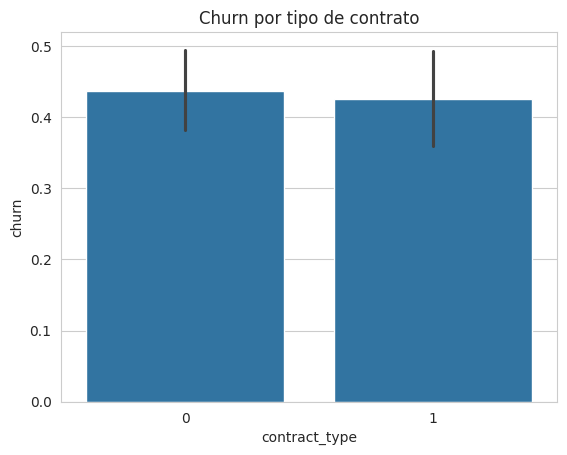

,churn
contract_type,
0,0.436426
1,0.425837


In [67]:
# Haciendo un barplot del churn/contract_type

sns.barplot(x= "contract_type", y= "churn", data= df)
plt.title("Churn por tipo de contrato")
plt.show()
df.groupby("contract_type")["churn"].mean()

In [68]:
df["usage_score"] = df["logins_per_week"] / (df["support_tickets"] + 1)
df.head()

,age,monthly_income,subscription_length,monthly_fee,support_tickets,logins_per_week,contract_type,churn,usage_score
0,56,4143,45,76,1,6,0,0,3.0
1,69,6108,27,97,1,4,1,1,2.0
2,46,4870,9,96,1,8,0,0,4.0
3,32,5599,26,68,1,0,1,1,0.0
4,60,2270,57,81,4,6,1,1,1.2


In [69]:
# Creando correlacion de usage_score/churn

df.corr(numeric_only= True)["churn"].sort_values()

,churn
subscription_length,-0.162791
age,-0.020299
contract_type,-0.010543
logins_per_week,-0.007894
usage_score,0.008032
monthly_income,0.011395
support_tickets,0.015025
monthly_fee,0.029178
churn,1.000000


In [70]:
# Creando funcion para entrenar modelos

def model_train(df):

  x = df.drop("churn", axis= 1)
  y = df["churn"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

  model = LogisticRegression(max_iter= 1000)
  model.fit(x_train, y_train)

  acc = accuracy_score(y_test, model.predict(x_test))

  return acc

In [71]:
# Accuracy con el df modificado

acc = model_train(df)
print(acc)

0.57


In [72]:
# Creando funcion para entrenar modelos con randomforest

def model_train_rand(df):

  x = df.drop("churn", axis= 1)
  y = df["churn"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

  model = RandomForestClassifier(random_state= 42)
  model.fit(x_train, y_train)

  acc = accuracy_score(y_test, model.predict(x_test))

  return acc

In [73]:
# Accuracy con randomforest

acc_2 = model_train_rand(df)
print(acc_2)

0.57


In [78]:
# Creando funcion para evaluar modelos con ROC usando logistic

def model_train_roc(df):

  x = df.drop("churn", axis= 1)
  y = df["churn"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

  model = LogisticRegression(max_iter= 1000)
  model.fit(x_train, y_train)

  y_prob = model.predict_proba(x_test)[:,-1]
  acc = roc_auc_score(y_test, y_prob)

  return acc

In [79]:
# Accuracy con ROC n logistic

acc = model_train_roc(df)
print(acc)

0.5796387520525452


In [95]:
# Creando funcion para evaluar modelos con ROC usando randomforest

def model_train_rand_roc(df):

  x = df.drop("churn", axis= 1)
  y = df["churn"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

  model = RandomForestClassifier(random_state= 42)
  model.fit(x_train, y_train)

  y_prob = model.predict_proba(x_test)[:,-1]
  acc = roc_auc_score(y_test, y_prob)

  return acc

In [96]:
acc = model_train_rand_roc(df)
acc

np.float64(0.555008210180624)

In [100]:
def model_train_rand_feat(df):

  x = df.drop("churn", axis= 1)
  y = df["churn"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

  model = RandomForestClassifier(random_state= 42)
  model.fit(x_train, y_train)

  feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

  return feat_imp

In [107]:
# Sacando vairables

def model_train_rand_feat(df):

  x = df.drop("churn", axis= 1)
  y = df["churn"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

  model = RandomForestClassifier(random_state= 42)
  model.fit(x_train, y_train)

  feat_imp = pd.Series(model.feature_importances_, index=x.columns).sort_values(ascending=False)

  return feat_imp

feat_imp = model_train_rand_feat(df)
feat_imp

,0
subscription_length,0.172913
monthly_income,0.171309
monthly_fee,0.168019
age,0.160975
usage_score,0.125560
logins_per_week,0.106098
support_tickets,0.066747
contract_type,0.028378


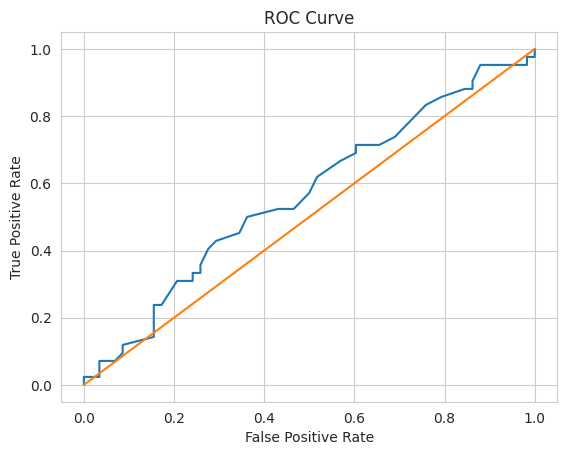

In [113]:
y_prob = model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])  # línea base
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Se diseñó un modelo de machine learning para predecir el churn en un servicio de suscripción, empleando un dataset sintético de clientes. Como primer paso, se realizó un análisis exploratorio de datos (EDA) acompañado de visualizaciones, lo que permitió identificar patrones clave en el comportamiento de los usuarios.

Posteriormente, se entrenaron dos modelos: Logistic Regression y Random Forest, evaluados mediante métricas de accuracy y ROC-AUC. El modelo de Logistic Regression obtuvo un mejor desempeño, lo que se explica por la naturaleza casi lineal de las relaciones presentes en los datos.

El análisis destacó que variables como la antigüedad del cliente, el ingreso mensual y la cuota del servicio tienen un impacto significativo en la retención. Estos hallazgos sugieren que la fidelización y la relación entre costo y capacidad de pago son factores determinantes en la probabilidad de churn.